In [1]:
#import av
import numpy as np
import math
from skimage.morphology import *
from skimage.feature import *
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vreader
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
grp1 = [1, [95, 67], 2]
grp2 = [2, [9.0], 13]
print(grp1+grp2)
print([grp1[i]+grp2[i] for i in range(len(grp1))])

[1, [95, 67], 2, 2, [9.0], 13]
[3, [95, 67, 9.0], 15]


In [3]:
filenames = filename = glob("./tchakamau/0.5*/*[1][0]v*_[0,1,7].avi")+glob("./tchakamau/0.5*/*[1][0]v*_10.avi")#[1,3,4,5]glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 5
Pass_ratios = np.zeros((len(filenames), num_shape_cats))



"""TEST FRAME RANGES FROM VIDEOs"""
phantom_frames = {"p" : [],#list(range(16312, 15312, -5)),
                  "g" :[], 
                  "b" :[],#list(range(21149, 19100, -10)),
                 "broken" :[] ,
                 "odd_s" :[]}#list(range(17192,17102,-1)) }
phantom_frames_2 = {"p" : list(range(77374, 71894, -25)),
                  "g" :list(chain(range(85588,81588, -20), range(35547,33657, -10))), 
                  "b" :[],
                 "broken" :list(range(78379, 77919,-3)),
                 "odd_s" :list(range(77911,77712,-1)) }
phantom_frames_3 = {"p" :list(range(48359,45359, -20)),
                  "g" :[], 
                  "b" :list(range(44732, 43731, -5)),
                 "broken" :[] ,
                 "odd_s" :[]}
phantom_frames_4 = {"p" :list(range(33701,31701, -10)) ,
                  "g" :[], 
                  "b" :list(range(60916,60193, -3)),
                 "broken" :list(range(34555,34288,-1)) ,
                 "odd_s" :list(range(61113,61059,-1)) }


phantom_frame_sets = [phantom_frames,phantom_frames_2,phantom_frames_3, phantom_frames_4]
trigger_frames = [21149, 85588,48500,61240]


['./tchakamau\\0.5 2nd\\45660_10Vpp_0.avi', './tchakamau\\0.5 2nd\\45660_10Vpp_1.avi', './tchakamau\\0.5 2nd\\45660_10Vpp_7.avi', './tchakamau\\0.5 2nd\\45660_10Vpp_10.avi']


In [4]:
p_frames = []

g_frames = []

b_frames = []

odd_s_frames = []

broken_frames = []


framesets = [p_frames, g_frames, b_frames,  odd_s_frames, 
             broken_frames]
framesetnames = ["p", "g", "b", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []    
for vidnum in range(len(filenames)):
    framegen = vreader(filenames[vidnum])
    #frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(framegen)
    pvals  = []
    gvals = []
    bvals = []
    oddsvals = []
    brokenvals = []
    frametypevals = [pvals, gvals, bvals, oddsvals, brokenvals]
    
    for framesetind in range(len(framesetnames)):
        typevals = (phantom_frame_sets[vidnum].get(framesetnames[framesetind]))
        frametypevals[framesetind].extend(typevals)
    frameindex = 0
    tf = trigger_frames[vidnum]
    for frame in framegen:
        for framesetind in range(len(framesetnames)):            
            if tf-frameindex in frametypevals[framesetind]:
                framesets[framesetind].append((frame[:,:,2], tf-frameindex))
           
        frameindex += 1
    
    
""" for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        
        frames = 
        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])
        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])
"""

<generator object vreader at 0x0000026E4A16F750>
<generator object vreader at 0x0000026E448CA228>
<generator object vreader at 0x0000026E4A16FA20>
<generator object vreader at 0x0000026E448CA228>


' for i in range(len(framesetnames)):\n        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])\n        \n        frames = \n        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])\n        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])\n'

In [5]:
# take largest isodata image region, and return aclassification
def sideify(ptotallengths,gtotallengths,mtotallengths,
                num_pconnections, num_gconnections, num_mconnections, mixedlen, mixed_prod, mixed_dotprod):    
    if num_gconnections == 0  and num_pconnections==1: #gtotallengths>48
        return "p"
    elif num_pconnections ==0 and num_gconnections>=1 :
        return "g"
    elif num_pconnections ==1 and num_gconnections>=1:
        return "b"
    else:
        return 'ucf'
    
def connect(cv, radius, bloblist): # center of blob2, radius of all blobs, list of other blobs
    num_connections = 0
    norm_radius = 15
    total_separations = 0
    normalized_dists = []
    mixedvecs = [] #2 mixed connection vectors
    for blob2 in bloblist:
        cv2 = (blob2[1], blob2[0]) # center of blob2
        vector_d = vector_dist(cv, cv2)
        total_separations += vector_d
        if vector_d <= 2*radius: # blob centers closer than diameter of one blob
            num_connections += 1
            mixedvecs.append((vector_sub(cv2,cv), vector_d))
        else:
            pass
        normalized_dists.append(vector_d/(2*norm_radius))
    return (num_connections, normalized_dists, total_separations, mixedvecs)

def vector_sub(b, a):
    sub = [b[i]-a[i] for i in range(min(len(b), len(a)))]
    return sub
def dot_prod(a,b):
    dot = [a[i]*b[i] for i in range(min(len(a), len(b)))]
    return dot

def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(min(len(v1), len(v2)))]))

def third_item(l1):
        return l1[2]        

#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [6]:
connect_test = connect((0, 0),2, [(0, 3, 1), (3, 3, 1.1), (0, 0, 5), (9, 9, 100)]) #2
vector_dist_test = [vector_dist((-3, 0), (0, 4)), vector_dist((1,1,0), (1,7,8))]
third_item_test = third_item([0, "99", "hello", [55, 67]])
print(connect_test, vector_dist_test , third_item_test )

(2, [0.1, 0.1414213562373095, 0.0, 0.4242640687119285], 19.97056274847714, [([3, 0], 3.0), ([0, 0], 0.0)]) [5.0, 10.0] hello


In [7]:
"Filtering broken ad oddframes"
"USING LI THRESHOLD"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    expected_blobs = 4
    expected_connections = 5
    p_bond = 15*1.2
    g_bond = 15*1.1
    m_bond = 15*1.6
    
    filtrate_prop =[]
    passes = []
    all_props = []
    blobset = [] #labelled imgs
    for i in range(fll):
       # ---setup image and detect blobs ----------------
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_li(frame)# binary image
        
        phighlight = morphology.binary_opening(thresh_img, disk(8))
        img = np.copy(frame)
        img[phighlight==0] = 0
        pblobs =skimage.feature.blob_doh(img, min_sigma =8, max_sigma = 17, threshold = 0.007, num_sigma= 15, overlap=0.6)
        
        ghighlight = gaussian(
        morphology.binary_opening(
             (thresh_img^phighlight)
                           , square(4)), sigma = 0.65)
        img = np.copy(frame)
        img[ghighlight==0] = 0
        gblobs =skimage.feature.blob_doh(img, min_sigma =9, max_sigma = 16, threshold = 0.005, num_sigma= 15, overlap=0.2)
    
        
        blobset.append([pblobs, gblobs])
        ngblobs = len(gblobs)
        npblobs = len(pblobs) 
        num_blobs = ngblobs + npblobs  
        
        def reducer(connections):
            return [sum([con[0] for con in connections]), 
                              list(chain(*[con[1] for con in connections])),
                             sum([con[2] for con in connections]),
                             list(chain(*[con[3] for con in connections]))]
            
        plas_on_glas_dists =[connect((pblob[1], pblob[0]),m_bond, gblobs) for pblob in pblobs]
        plas_on_glas_dists = reducer(plas_on_glas_dists)
        
        num_mconnections = plas_on_glas_dists[0]
        mdistances = plas_on_glas_dists[1]
        mtotallengths = plas_on_glas_dists[2]
        
        glas_on_glas_dists =[connect((gblobs[i][1], gblobs[i][0]),g_bond, gblobs[i+1:]) for i in range(ngblobs-1)]
        glas_on_glas_dists = reducer(glas_on_glas_dists)
        
        num_gconnections = glas_on_glas_dists[0]
        gdistances = glas_on_glas_dists[1]
        gtotallengths = glas_on_glas_dists[2]
        
        plas_on_plas_dists = [connect((pblobs[i][1], pblobs[i][0]),p_bond, pblobs[i+1:]) for i in range(npblobs-1)]
        plas_on_plas_dists = reducer(plas_on_plas_dists)
        """[sum([pop[0] for pop in plas_on_plas_dists]), 
                              list(chain(*[pop[1] for pop in plas_on_plas_dists])),
                             sum([pop[2] for pop in plas_on_plas_dists]),
                             list(chain(*[pop[3] for pop in plas_on_plas_dists]))]"""
        num_pconnections = plas_on_plas_dists[0]
        pdistances = plas_on_plas_dists[1]
        ptotallengths = plas_on_plas_dists[2]
        mixedvecs = plas_on_plas_dists[3]
        
        
        num_connections = sum([num_pconnections, num_gconnections,num_mconnections])
        distances = list(chain(pdistances, gdistances, mdistances))       
        totallengths = sum([ptotallengths, gtotallengths, mtotallengths])
        #print(mixedvecs)
        mixedlen = len(mixedvecs)
        mixed_prod = abs(np.prod([a[1] for a in mixedvecs]))
        if mixedlen <0:            
            mixed_dotprod = abs(dot_prod([a[0] for a in mixedvecs]))
            #print(mixed_dotprod)
        else:
            mixed_dotprod =15
        #----------------------filter------------------------- can use actual filter
        properties = {'num_blobs':num_blobs,
                      'num_pblobs':npblobs,
                      'num_gblobs':ngblobs,
                      'num_connections': num_connections,
                      'num_pconnections':num_pconnections, 
                      'num_gconnections':num_gconnections, 
                      'num_mconnections':num_mconnections,
                     'totallengths':totallengths, 
                      'ptotallengths':ptotallengths, 
                      'gtotallengths':gtotallengths, 
                      'mtotallengths':mtotallengths,
                     'distances':distances, 
                      'pdistances':pdistances, 
                      'gdistances':gdistances, 
                      'mdistances':mdistances,
                     'mixed_dotprod':mixed_dotprod}
        #print(properties)
        all_props.append(properties)
        
        #print('blobs, max_blob, max_rad, num_connections, cons_of_max:', (blobs, max_blob, max_rad, num_connections, cons_of_max))    
        test = (num_connections >= expected_connections and num_blobs>=expected_blobs)
        if test: 
            #-----------------------------classify pt 1---------------------------------------
            
            clas = sideify(ptotallengths,gtotallengths,mtotallengths,
                num_pconnections,num_gconnections, num_mconnections,mixedlen, mixed_prod, mixed_dotprod)
            filtrate_prop.append(properties)
        else:
            clas = 'ucf'
        if clas == framesetname:
            passes.append(properties)
            
    return [filtrate_prop, passes, all_props, blobset]






In [8]:
filtrates_props = []
passes = []
a_props = []
p_rats = []
limgs = []
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    passes.append(x[1])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(framesets[i])
    fil = len(x[0])
    pas = len(x[1])
    print(orig, fil, pas)
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", pas*100/orig)
        p_rats.append(pas*100/orig)
    print("\n")
        

    a_props.append(x[2])
    limgs.append(x[3])
Pass_ratios = p_rats
Filtrates_props = filtrates_props
st = framesets
np.save('shape_testing.npy',st)
print(len(a_props), len(filtrates_props), len(passes))

570 552 495
p _vid
original_vid:  570
filtrate:  552
pass ratio:  86.84210526315789


389 364 363
g _vid
original_vid:  389
filtrate:  364
pass ratio:  93.31619537275064


442 410 408
b _vid
original_vid:  442
filtrate:  410
pass ratio:  92.3076923076923


253 67 186
odd_s _vid
original_vid:  253
filtrate:  67
pass ratio:  73.51778656126483


421 17 404
broken _vid
original_vid:  421
filtrate:  17
pass ratio:  95.96199524940617


5 5 5


In [9]:
names = {'num_blobs':[],
                      'num_pblobs':[],
                      'num_gblobs':[],
                      'num_connections': [],
                      'num_pconnections':[], 
                      'num_gconnections':[], 
                      'num_mconnections':[],
                     'totallengths':[], 
                      'ptotallengths':[], 
                      'gtotallengths':[], 
                      'mtotallengths':[],
                     'distances':[], 
                      'pdistances':[], 
                      'gdistances':[], 
                      'mdistances':[],
                     'mixed_dotprod':[]}
strings = names.keys()
distances = [string for string in strings if 'distances' in string]
simplenames = strings - distances
print(distances, simplenames)

['distances', 'pdistances', 'gdistances', 'mdistances'] {'num_blobs', 'num_gblobs', 'totallengths', 'ptotallengths', 'num_pconnections', 'num_pblobs', 'num_mconnections', 'mixed_dotprod', 'gtotallengths', 'num_connections', 'num_gconnections', 'mtotallengths'}


num_blobs averages: 
p : 5 
g : 7 
b : 4 
odd_s : 6 
broken : 5 
num_blobs variances: 
p : 2 
g : 0 
b : 0 
odd_s : 2 
broken : 2 
num_gblobs averages: 
p : 3 
g : 5 
b : 2 
odd_s : 4 
broken : 3 
num_gblobs variances: 
p : 2 
g : 0 
b : 0 
odd_s : 2 
broken : 2 
totallengths averages: 
p : 852 
g : 1890 
b : 173 
odd_s : 1689 
broken : 1142 
totallengths variances: 
p : 730142 
g : 44490 
b : 1082 
odd_s : 703359 
broken : 749601 
ptotallengths averages: 
p : 31 
g : 45 
b : 29 
odd_s : 43 
broken : 51 
ptotallengths variances: 
p : 4 
g : 125 
b : 8 
odd_s : 208 
broken : 1032 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


num_pconnections averages: 
p : 1 
g : 0 
b : 1 
odd_s : 0 
broken : 1 
num_pconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 2 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_mconnections averages: 
p : 4 
g : 4 
b : 4 
odd_s : 3 
broken : 2 
num_mconnections variances: 
p : 0 
g : 1 
b : 0 
odd_s : 1 
broken : 0 
mixed_dotprod averages: 
p : 15 
g : 15 
b : 15 
odd_s : 15 
broken : 15 
mixed_dotprod variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
gtotallengths averages: 
p : 470 
g : 1102 
b : 26 
odd_s : 956 
broken : 554 
gtotallengths variances: 
p : 299884 
g : 29288 
b : 84 
odd_s : 275049 
broken : 315152 
num_connections averages: 
p : 5 
g : 5 
b : 5 
odd_s : 4 
broken : 3 
num_connections variances: 
p : 1 
g : 2 
b : 1 
odd_s : 3 
broken : 1 
num_gconnections averages: 
p : 0 
g : 1 
b : 1 
odd_s : 0 
broken : 0 
num_gconnections variances: 
p : 0 
g : 0 
b : 0 

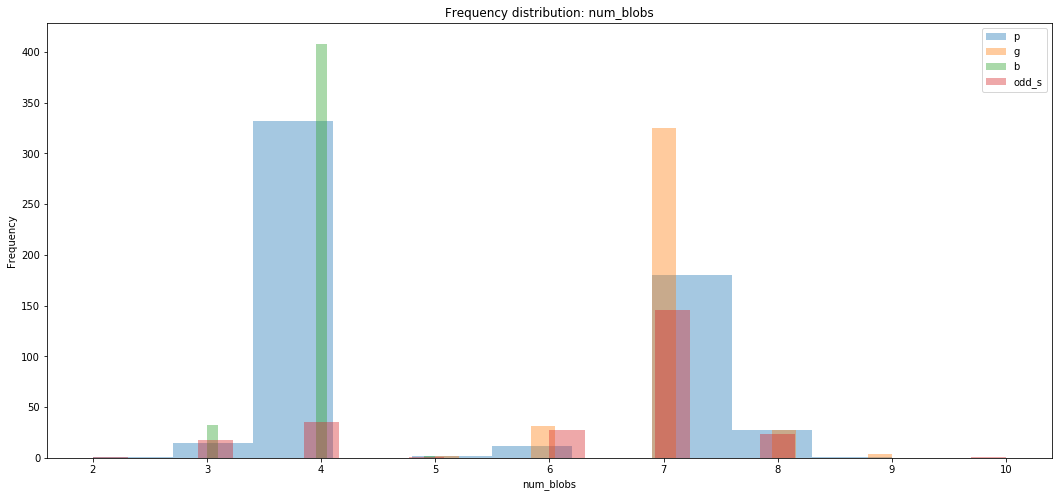

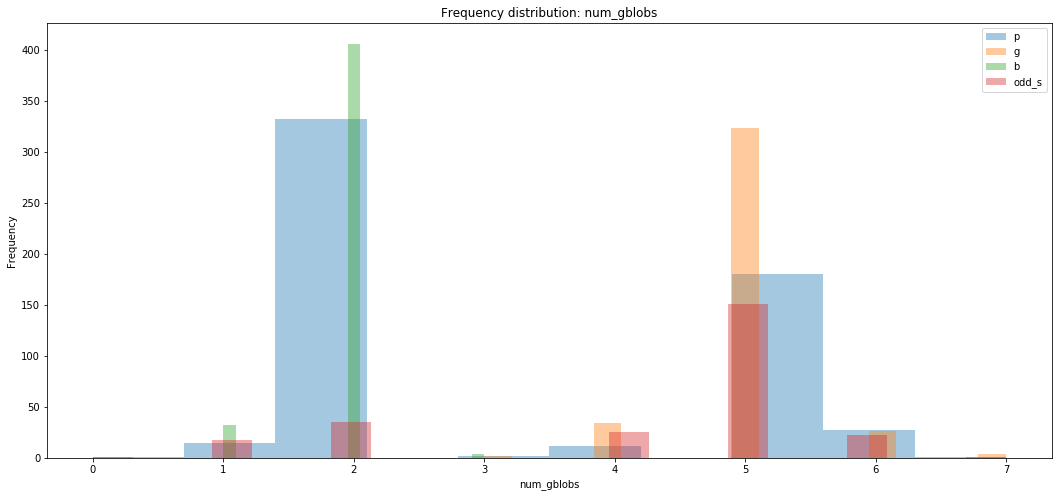

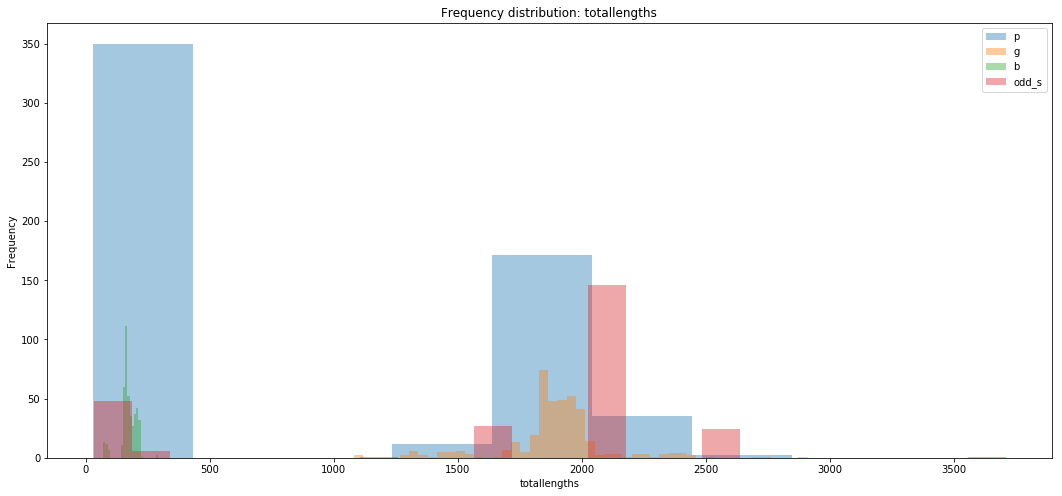

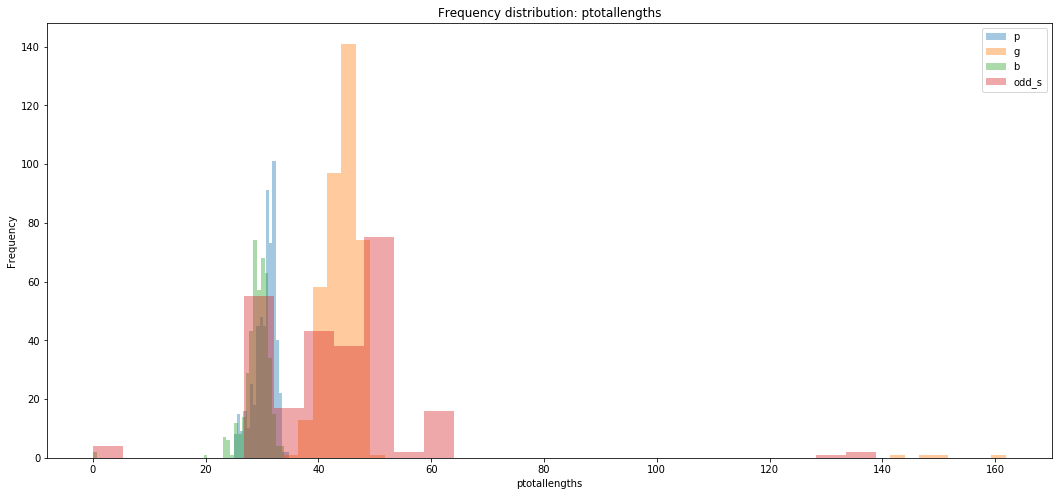

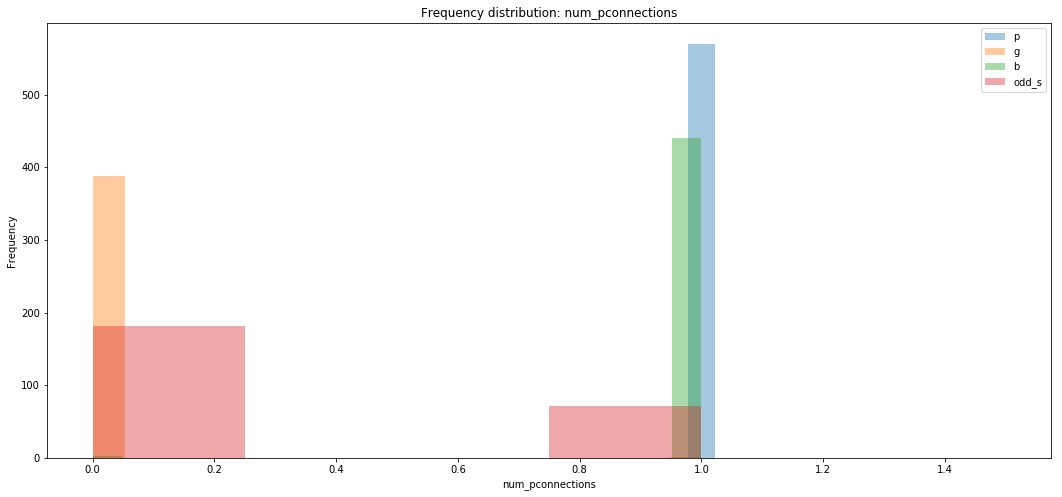

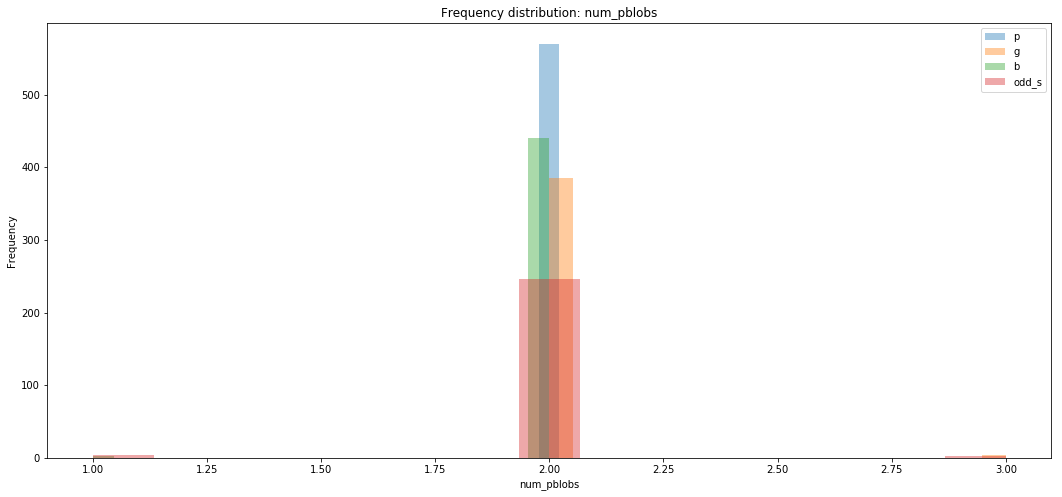

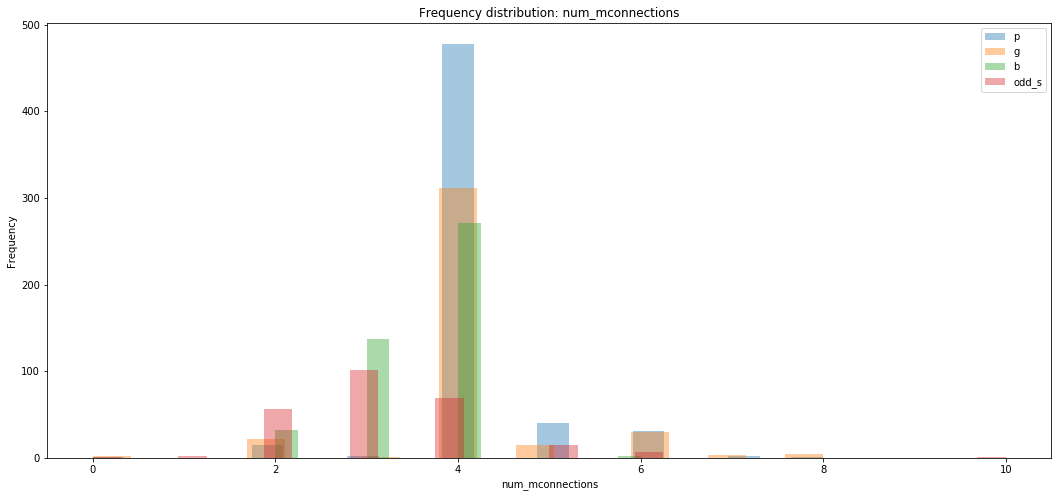

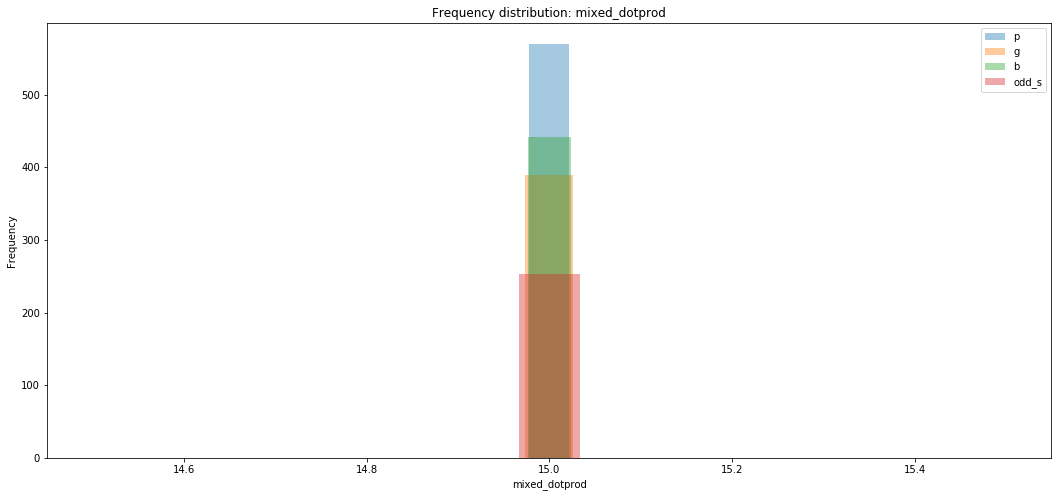

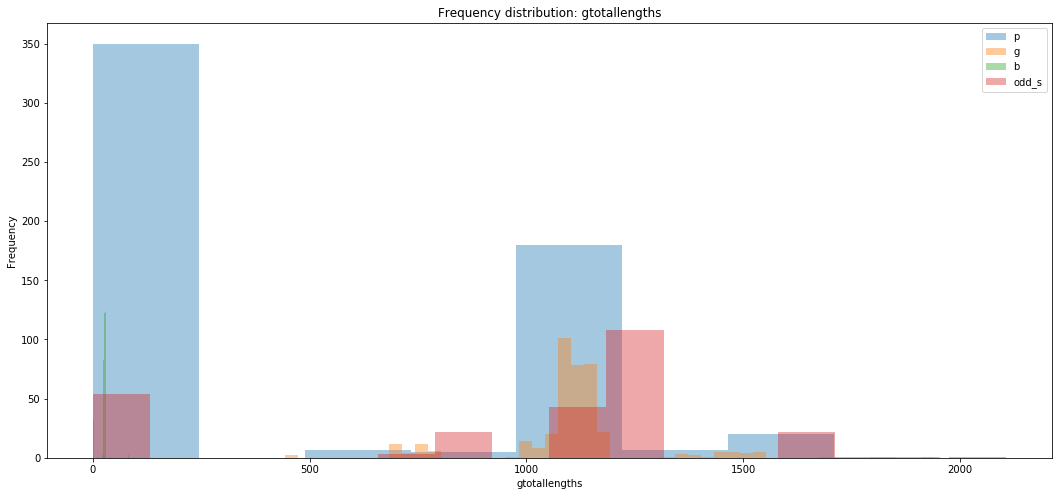

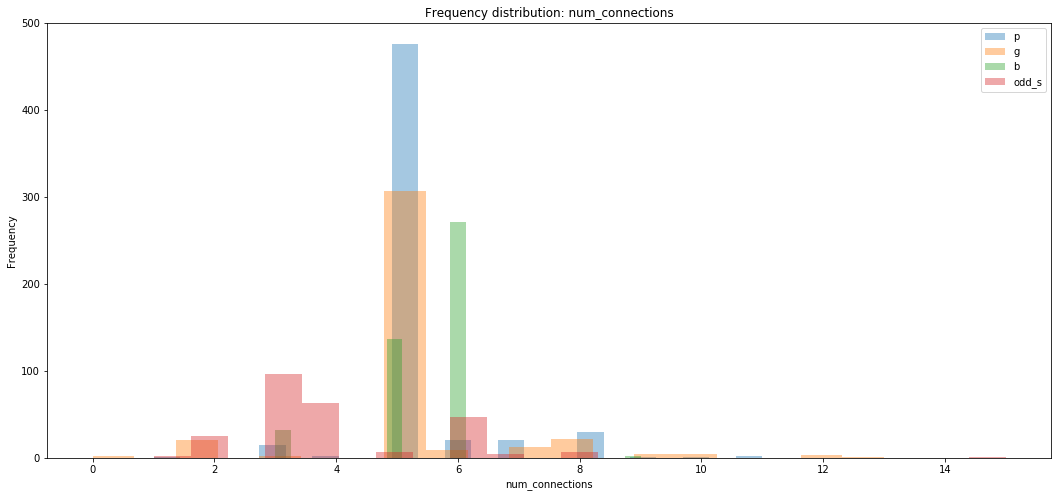

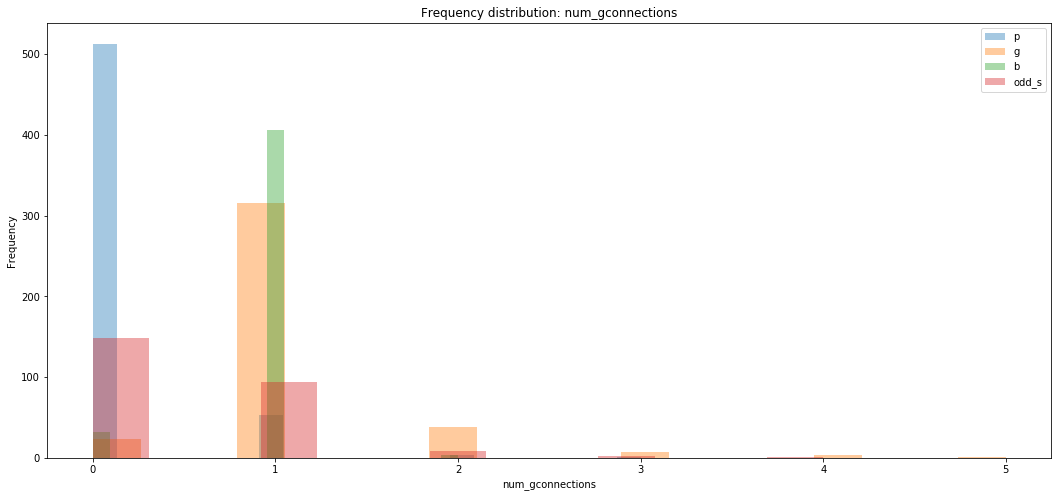

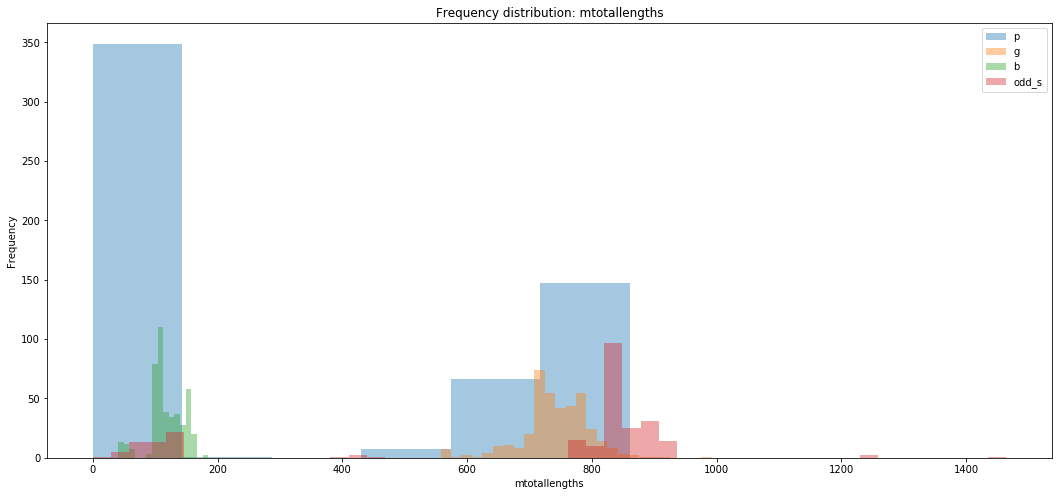

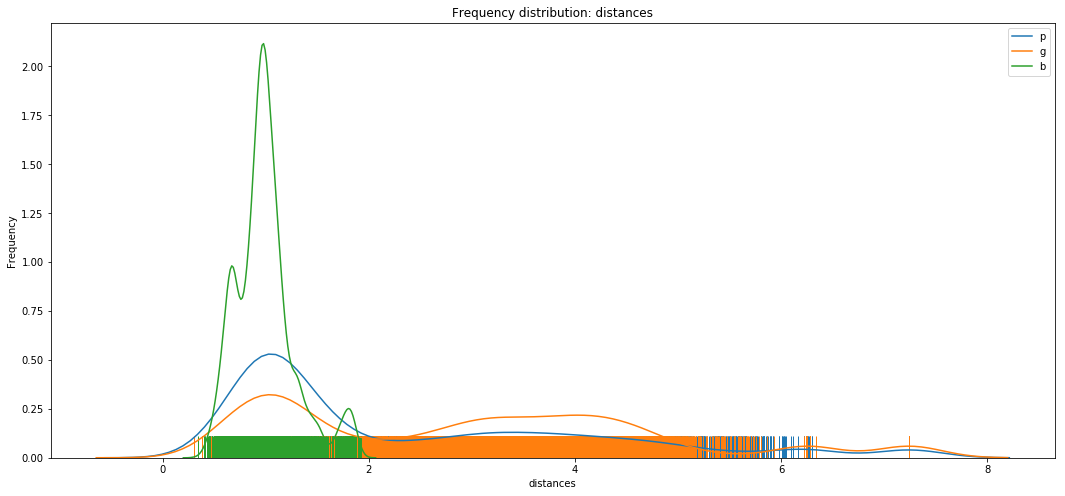

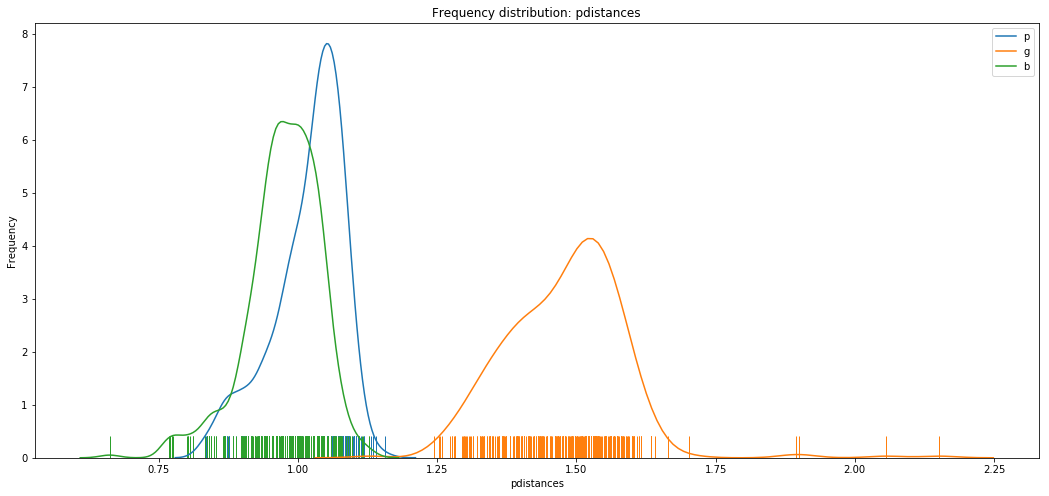

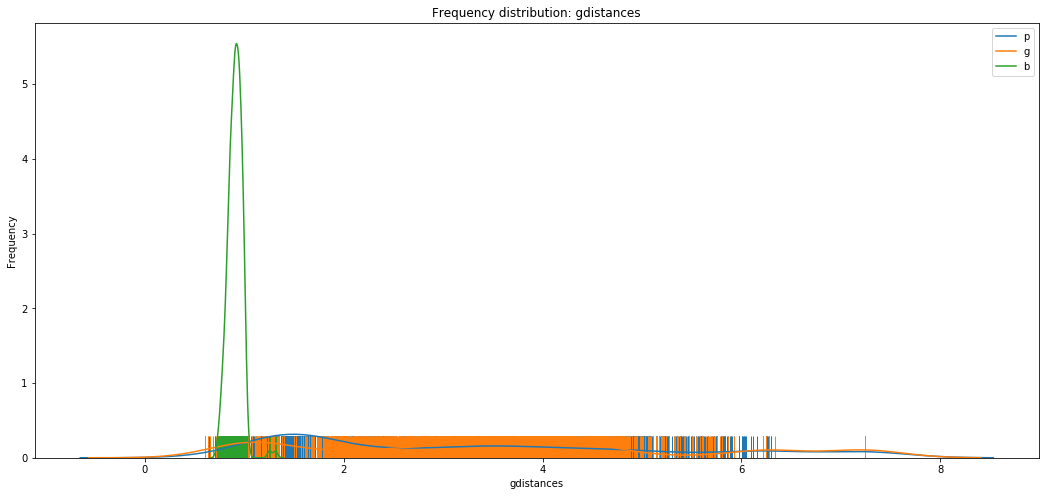

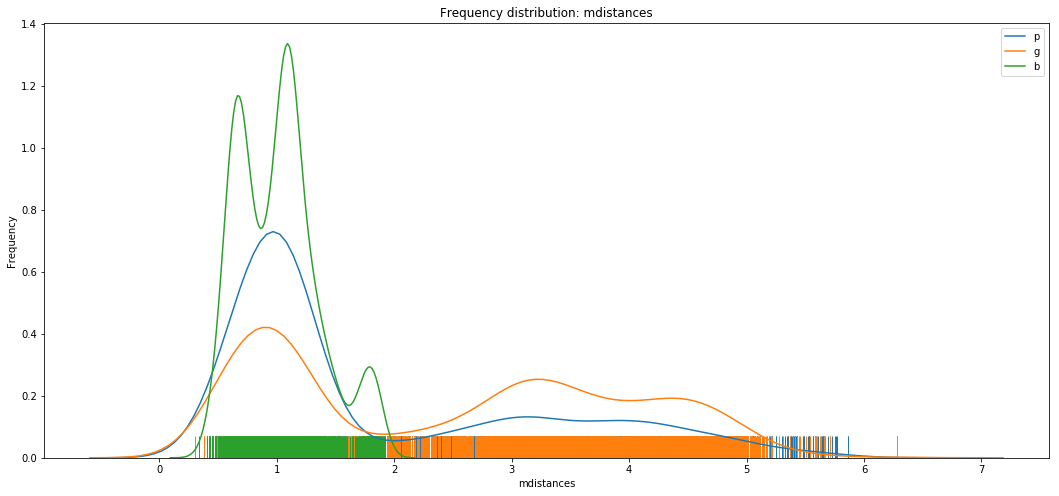

In [10]:
"""Everything"""

# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in a_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in a_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-2):
        x = klist[j]
        sns.distplot(x, hist = False, norm_hist=False,rug=True, label = framesetnames[j])




num_blobs averages: 
p : 5 
g : 7 
b : 4 
odd_s : 6 
broken : 6 
num_blobs variances: 
p : 2 
g : 0 
b : 0 
odd_s : 4 
broken : 3 
num_gblobs averages: 
p : 3 
g : 5 
b : 2 
odd_s : 4 
broken : 4 
num_gblobs variances: 
p : 2 
g : 0 
b : 0 
odd_s : 4 
broken : 3 
totallengths averages: 
p : 872 
g : 1921 
b : 180 
odd_s : 1286 
broken : 1260 
totallengths variances: 
p : 735369 
g : 32016 
b : 488 
odd_s : 1393707 
broken : 1272379 
ptotallengths averages: 
p : 31 
g : 46 
b : 29 
odd_s : 42 
broken : 41 
ptotallengths variances: 
p : 4 
g : 132 
b : 8 
odd_s : 467 
broken : 141 
num_pconnections averages: 
p : 1 
g : 0 
b : 1 
odd_s : 1 
broken : 1 
num_pconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 2 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_mconnections averages: 
p : 4 
g : 4 
b : 4 
odd_s : 4 
broken : 4 
num_mconnections variances: 
p : 0 
g : 1 
b : 0 
odd_s : 1 
br

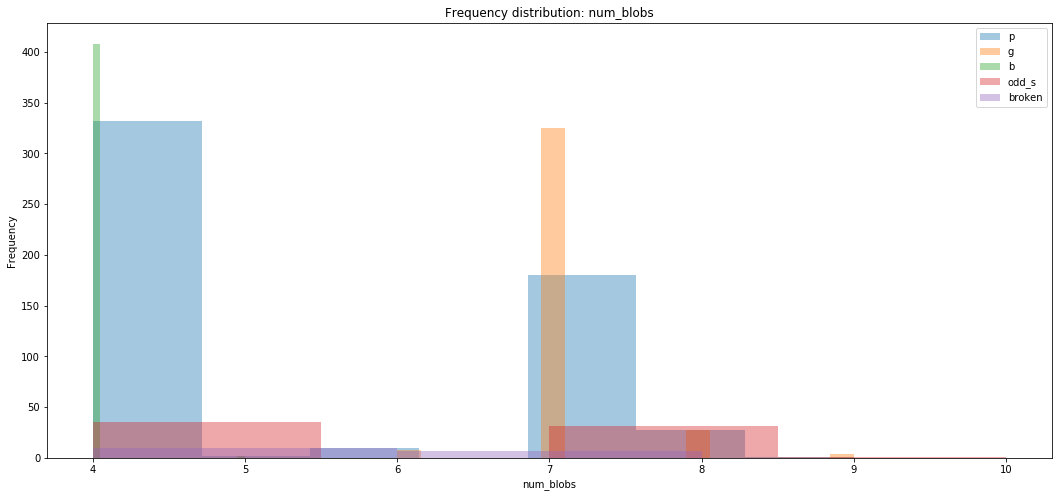

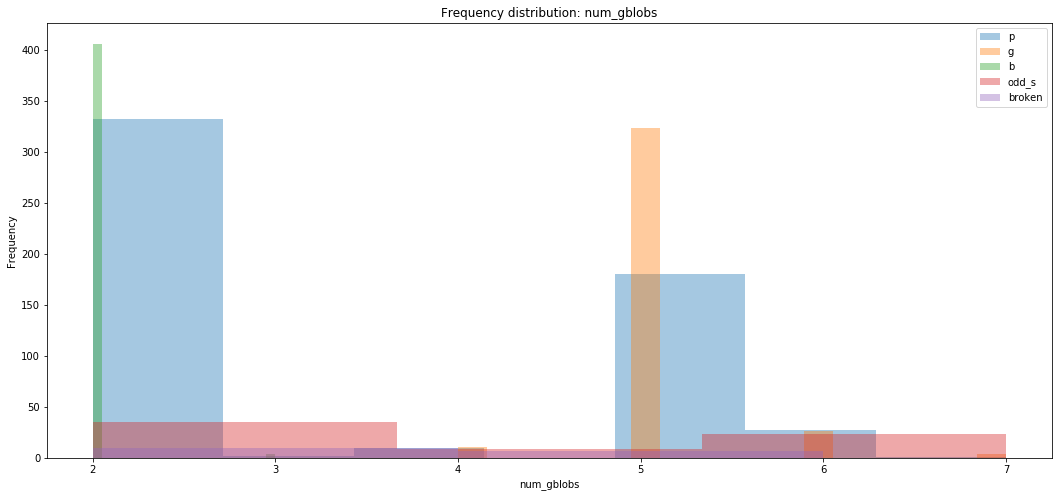

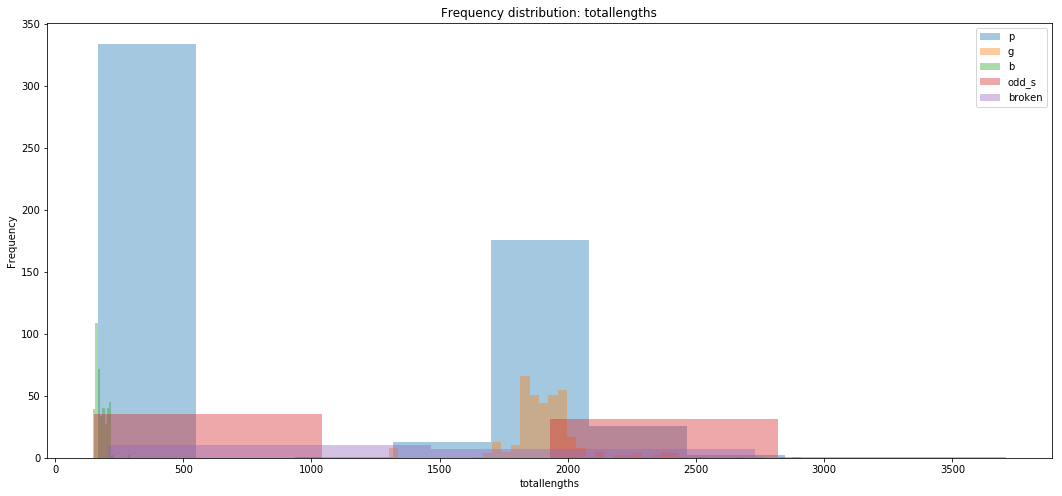

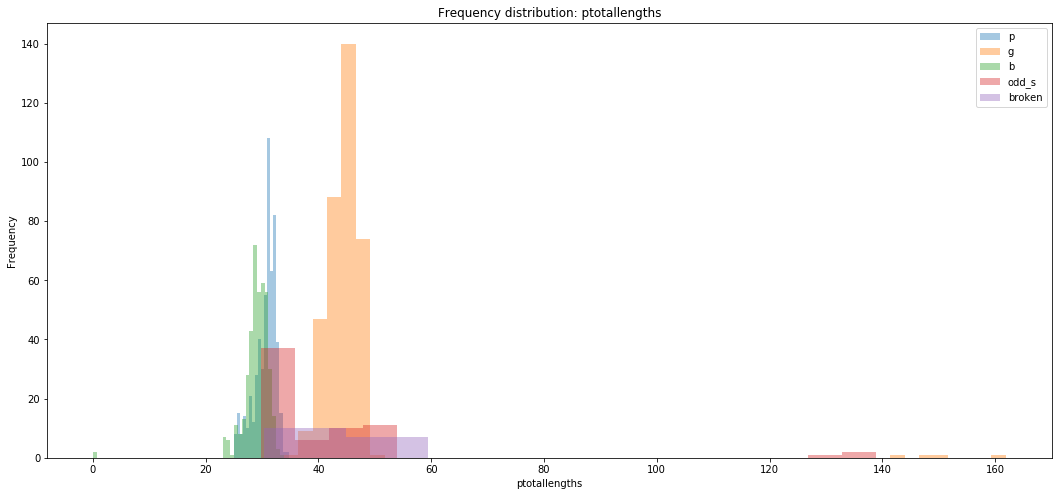

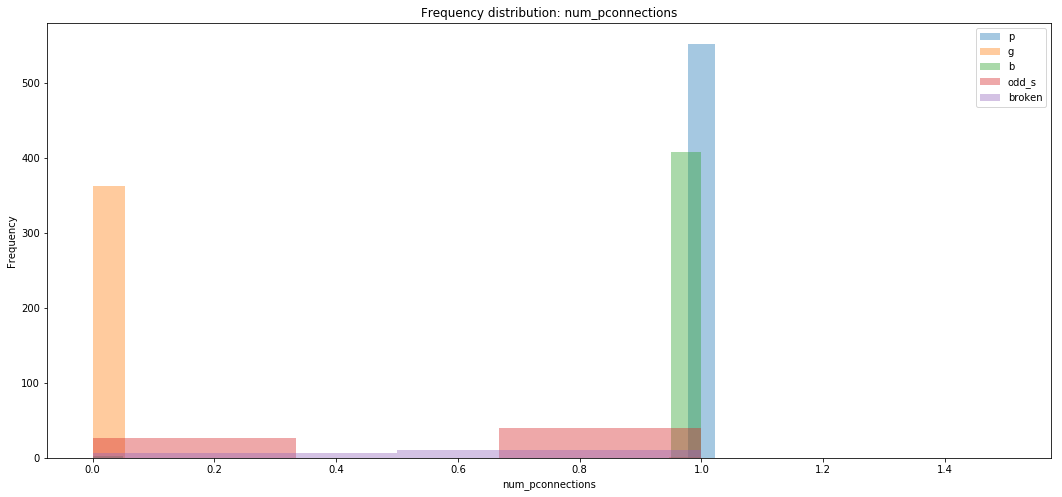

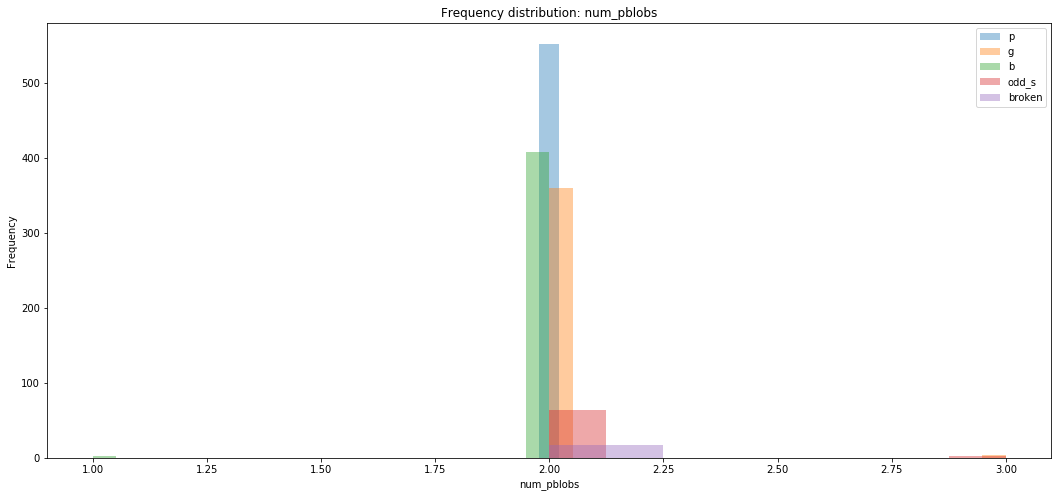

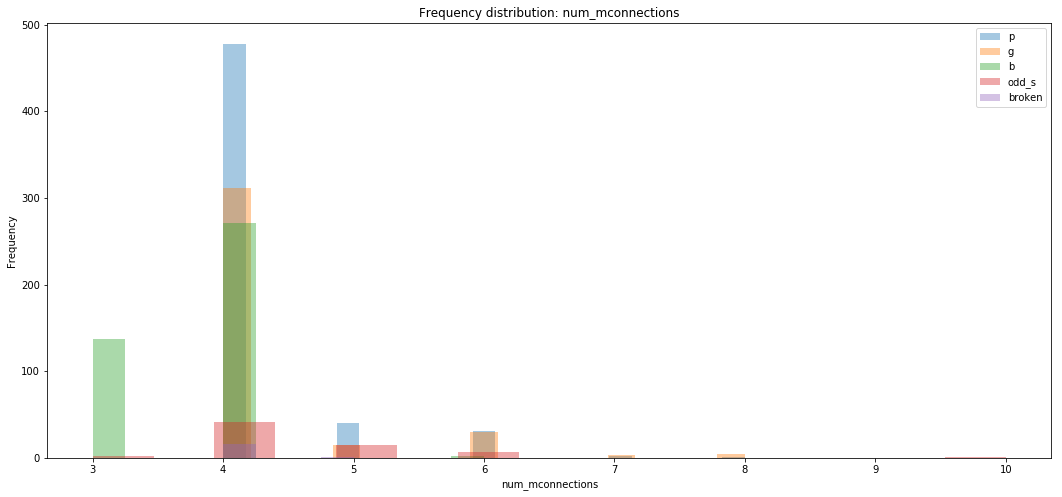

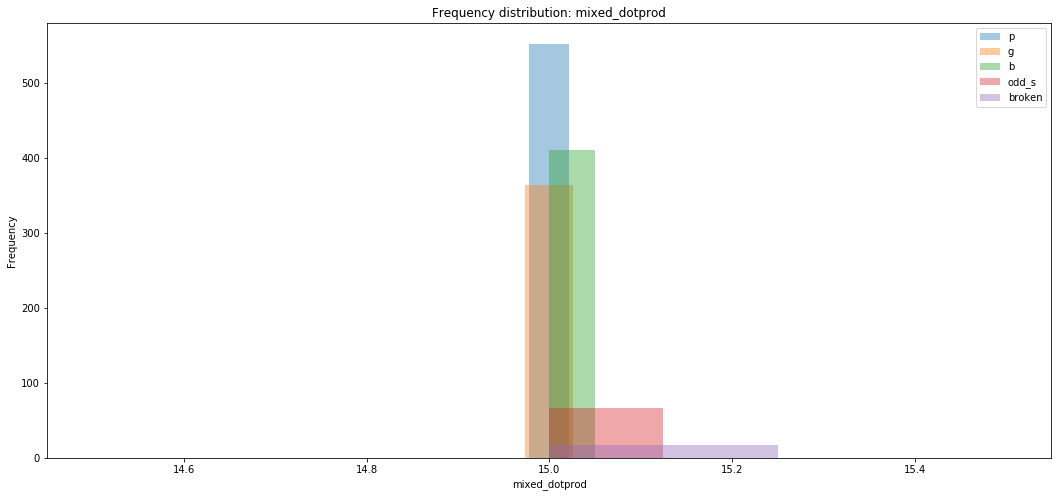

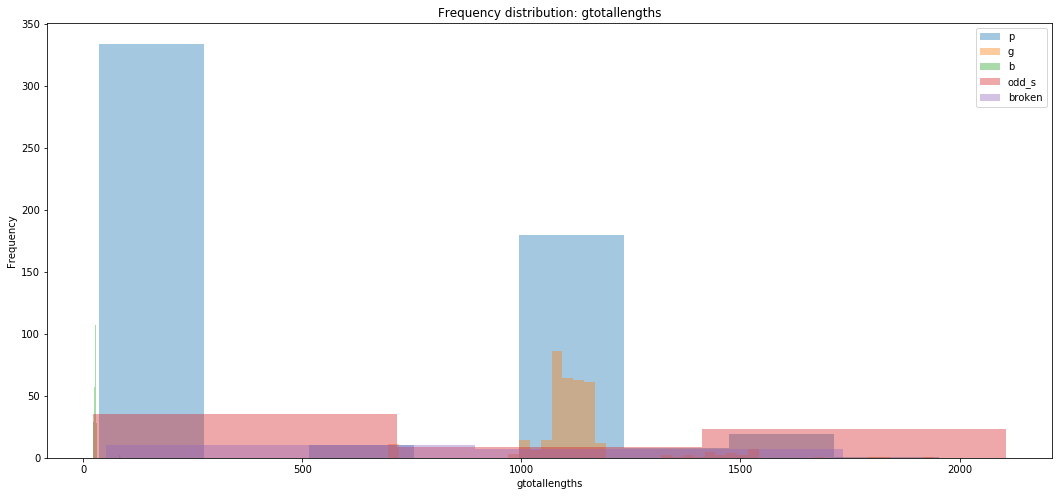

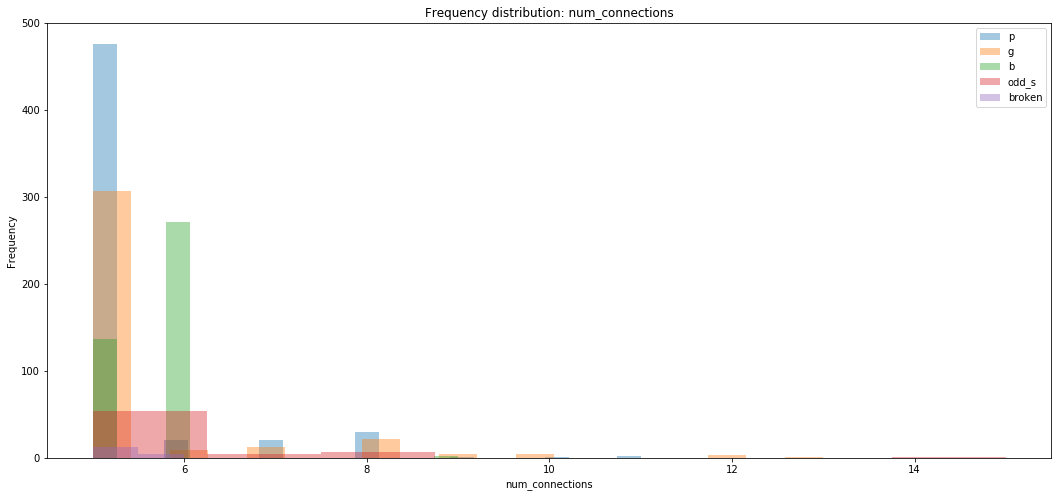

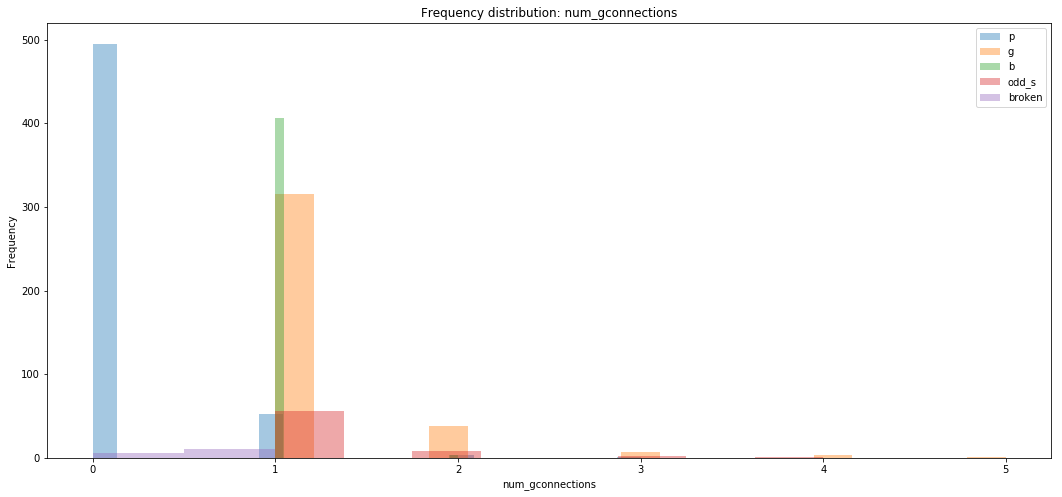

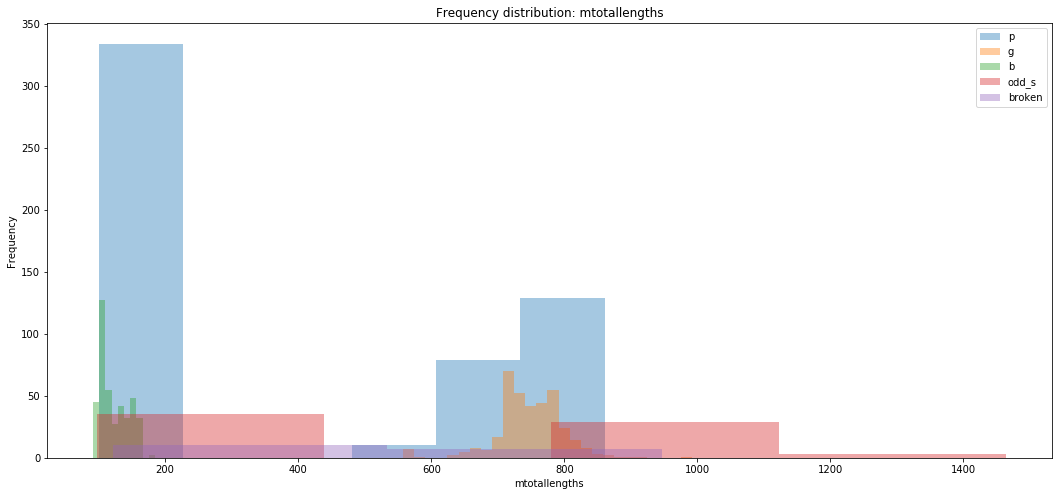

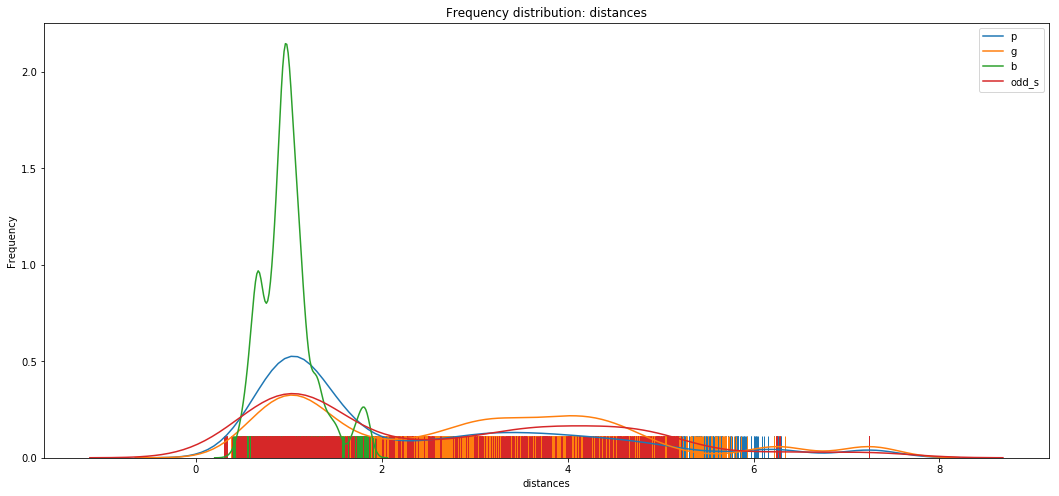

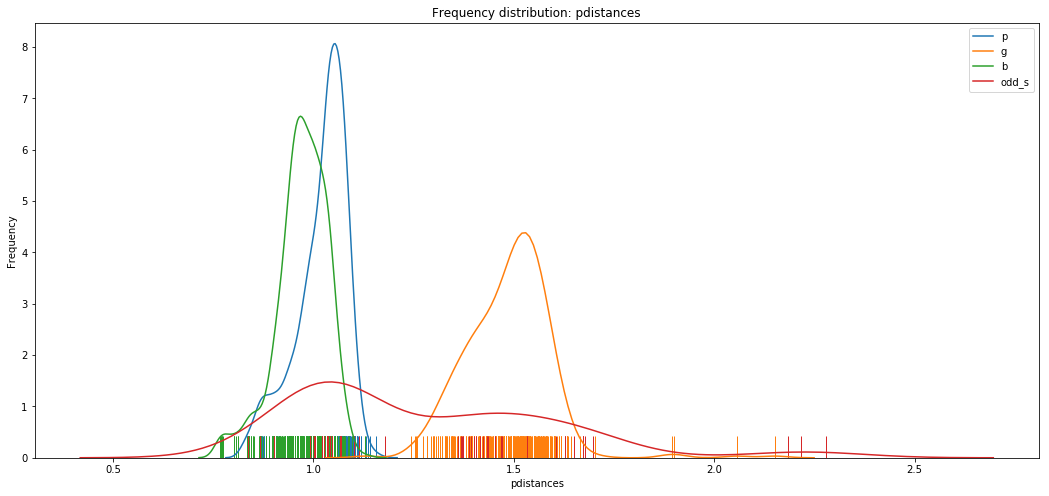

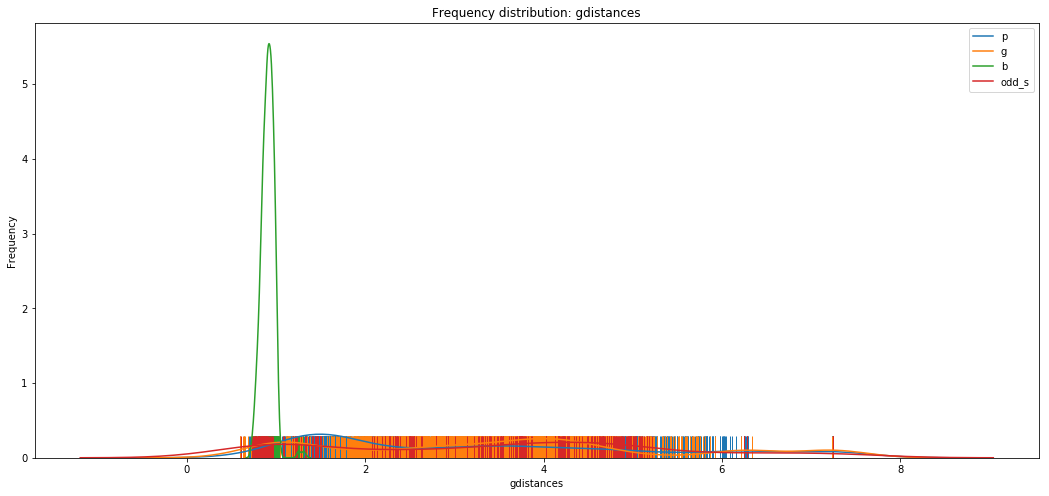

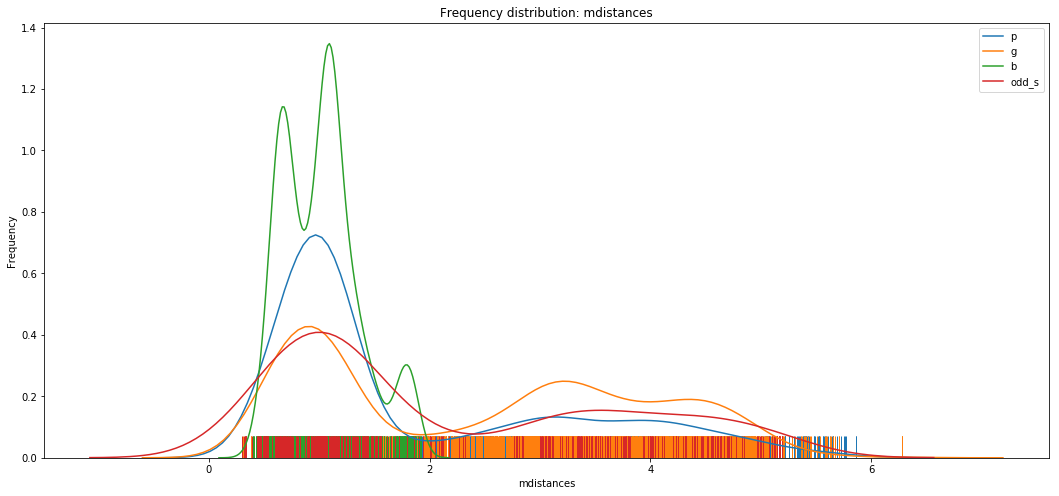

In [11]:
"""After first tests"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in filtrates_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])



num_blobs averages: 
p : 5 
g : 7 
b : 4 
odd_s : 6 
broken : 5 
num_blobs variances: 
p : 2 
g : 0 
b : 0 
odd_s : 2 
broken : 2 
num_gblobs averages: 
p : 3 
g : 5 
b : 2 
odd_s : 4 
broken : 3 
num_gblobs variances: 
p : 2 
g : 0 
b : 0 
odd_s : 2 
broken : 2 
totallengths averages: 
p : 744 
g : 1920 
b : 180 
odd_s : 1834 
broken : 1137 
totallengths variances: 
p : 638752 
g : 31890 
b : 490 
odd_s : 375344 
broken : 726995 
ptotallengths averages: 
p : 30 
g : 46 
b : 29 
odd_s : 44 
broken : 51 
ptotallengths variances: 
p : 4 
g : 132 
b : 4 
odd_s : 113 
broken : 1065 
num_pconnections averages: 
p : 1 
g : 0 
b : 1 
odd_s : 0 
broken : 1 
num_pconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 2 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_mconnections averages: 
p : 4 
g : 4 
b : 4 
odd_s : 3 
broken : 2 
num_mconnections variances: 
p : 0 
g : 1 
b : 0 
odd_s : 1 
bro

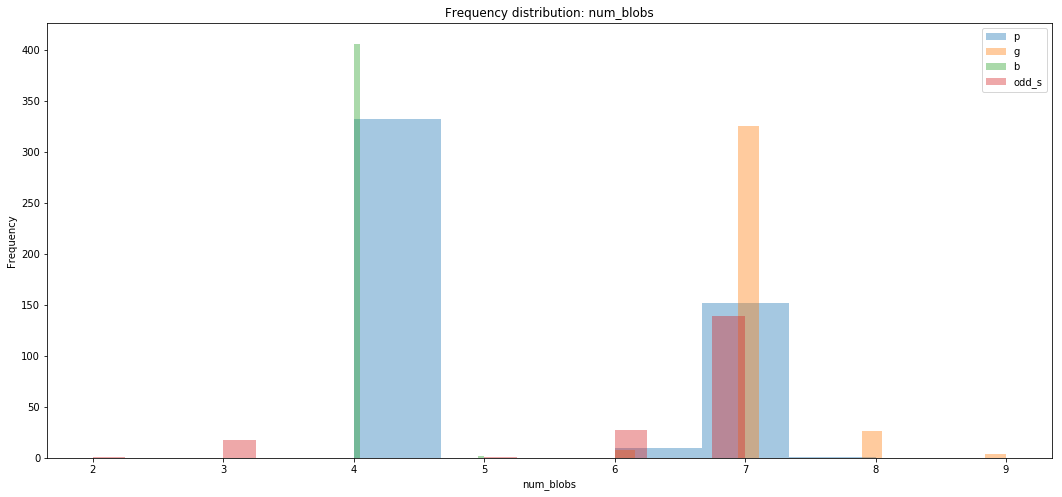

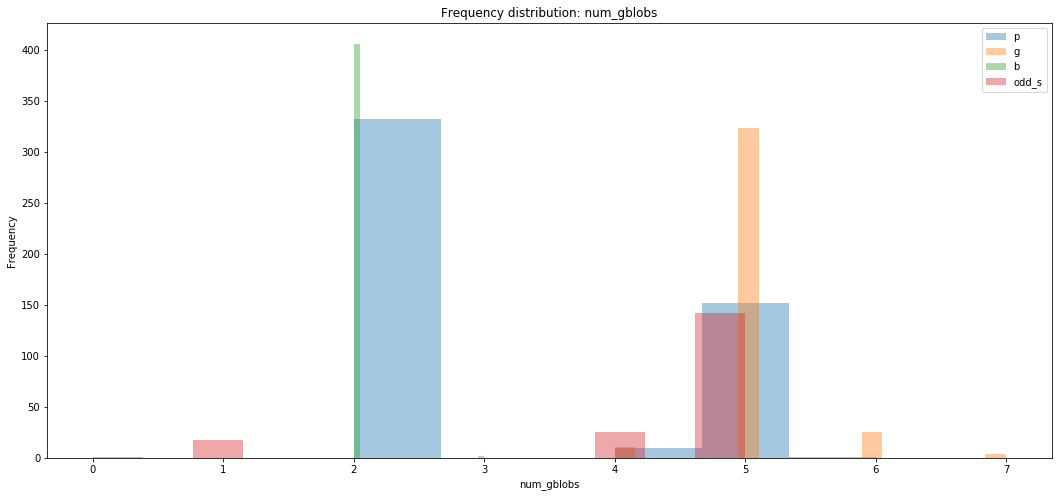

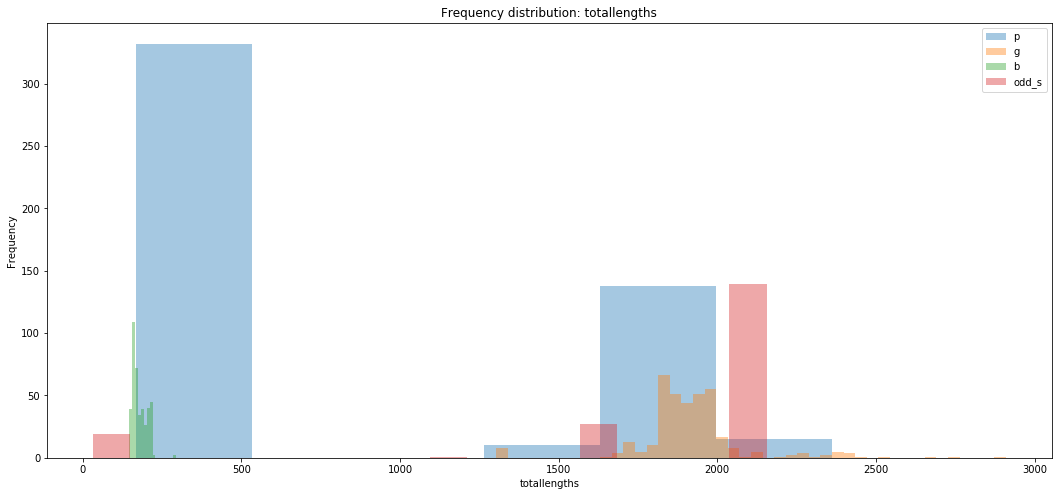

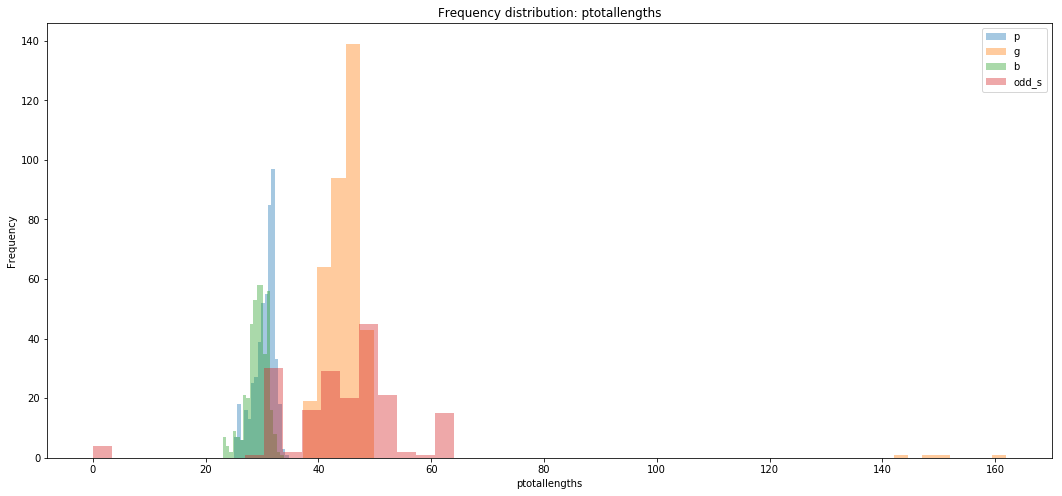

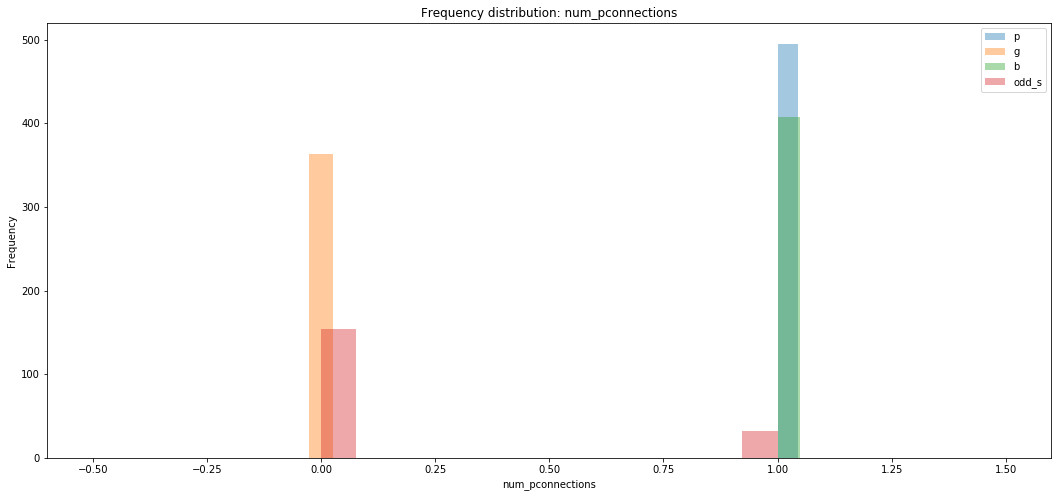

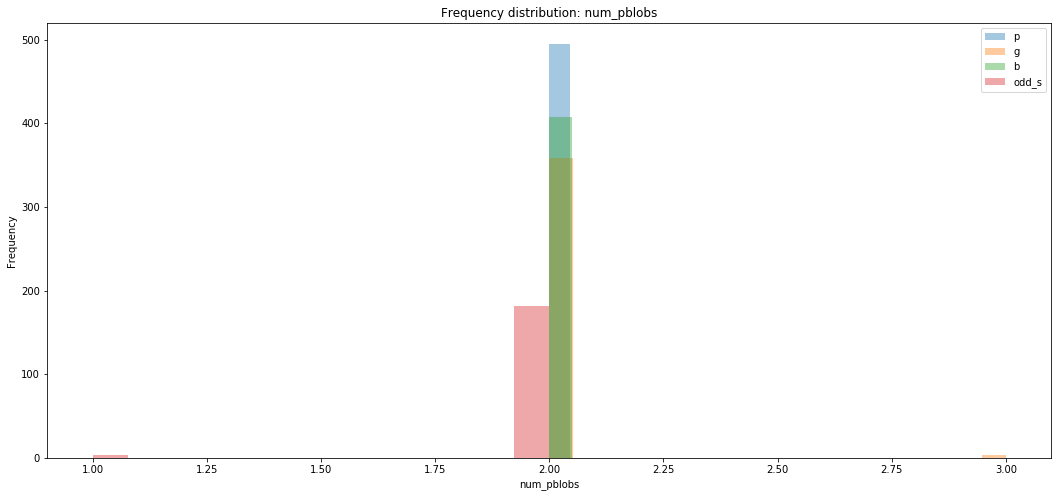

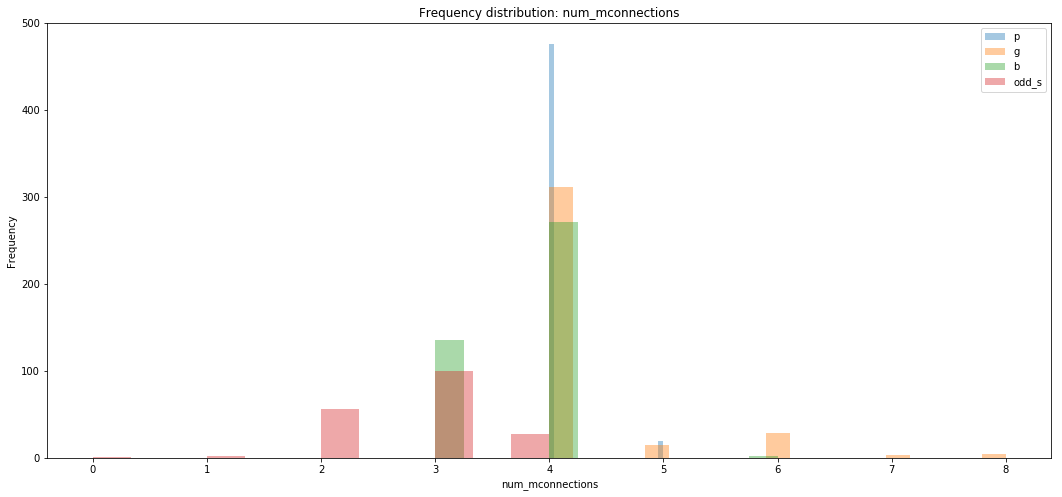

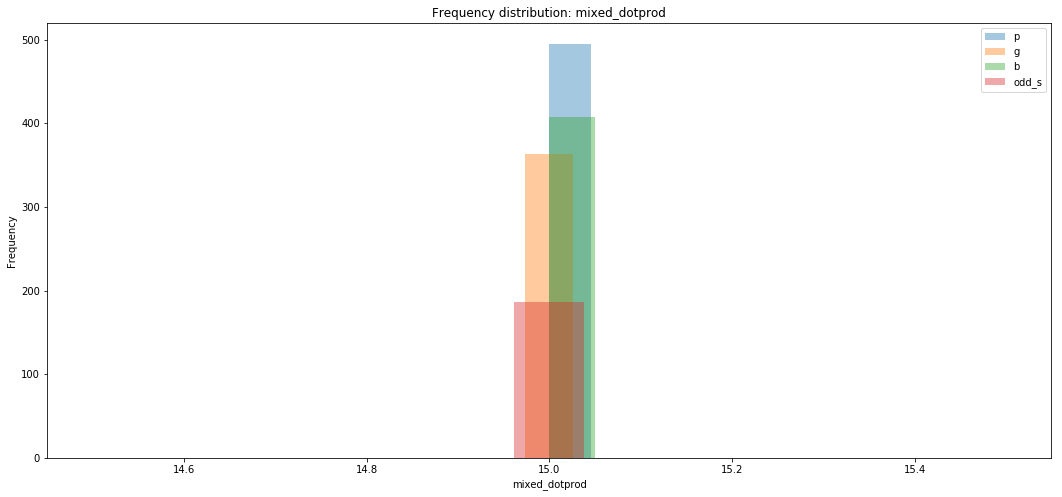

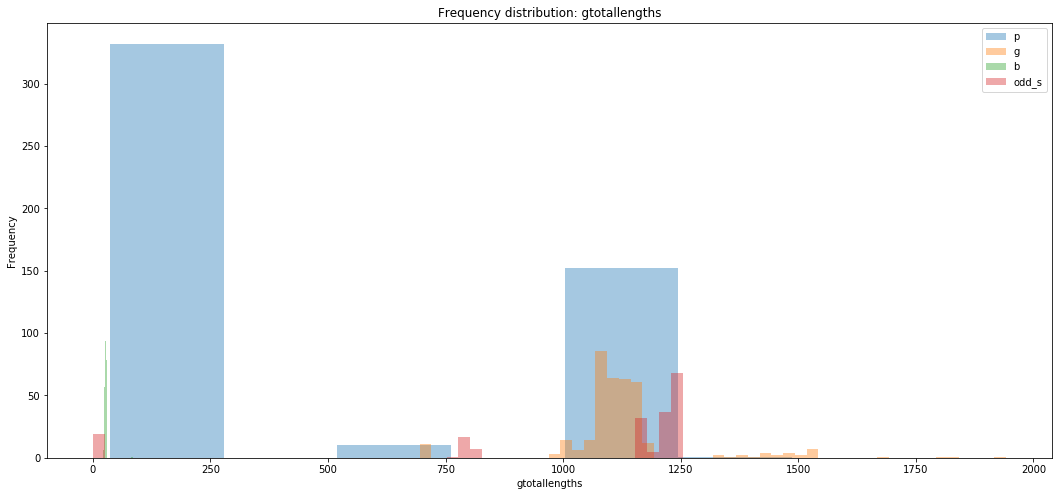

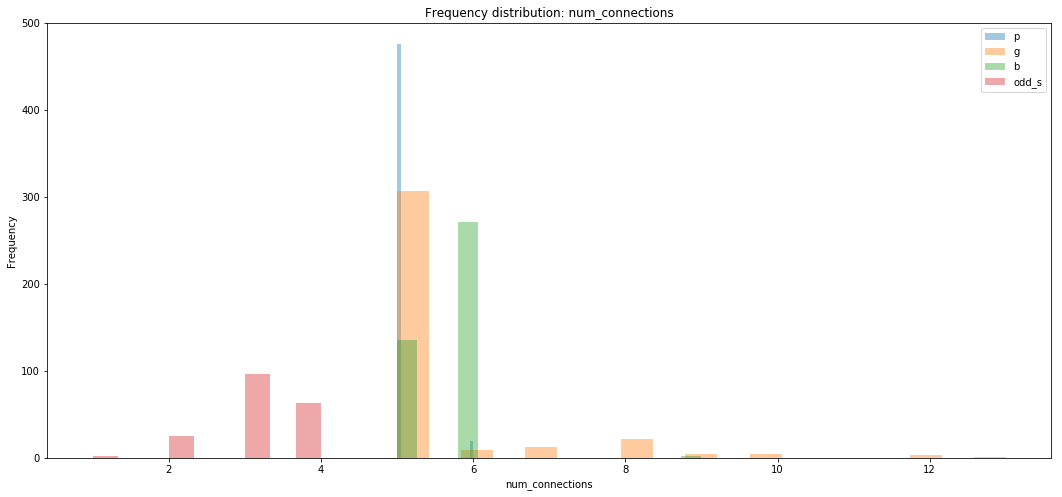

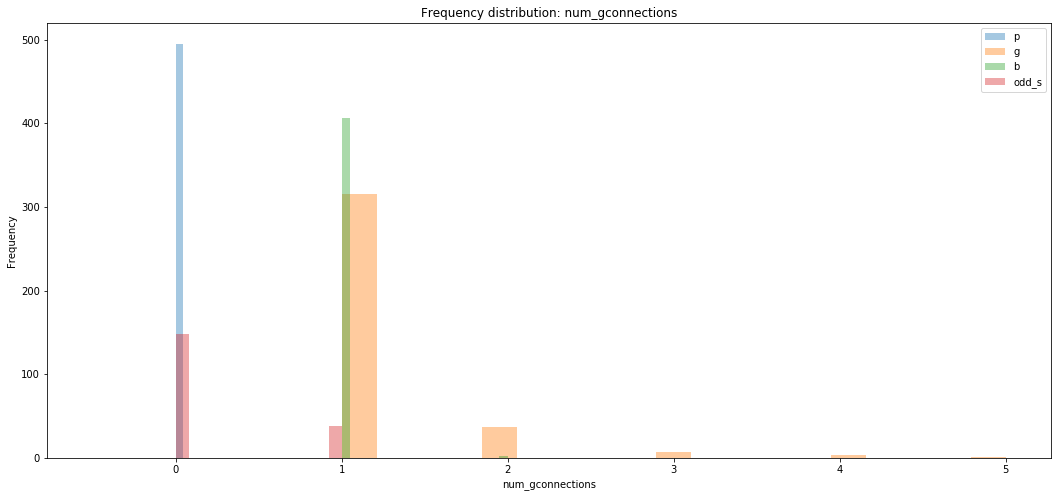

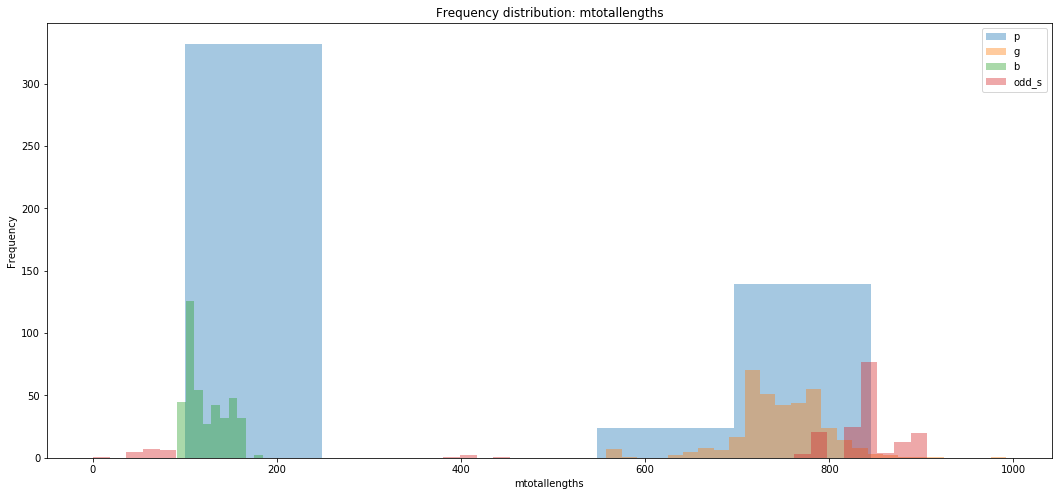

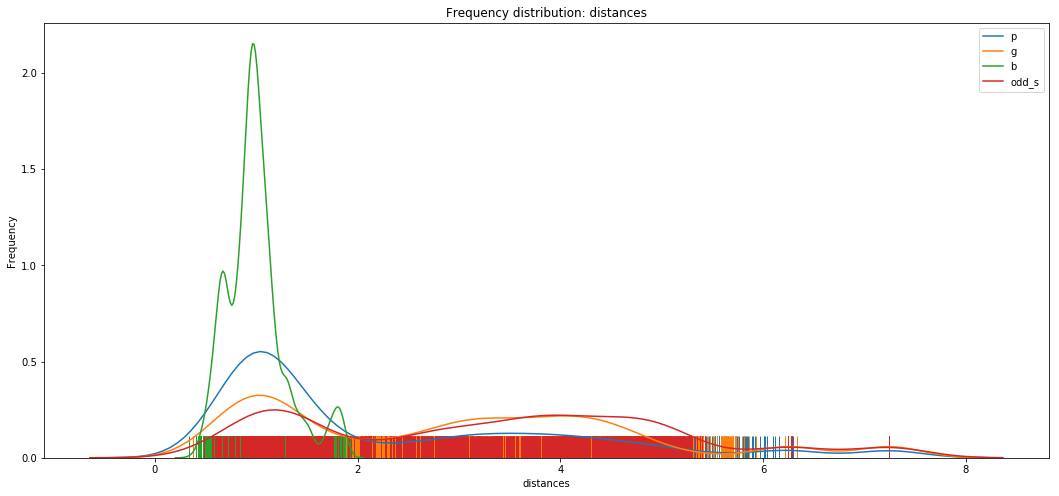

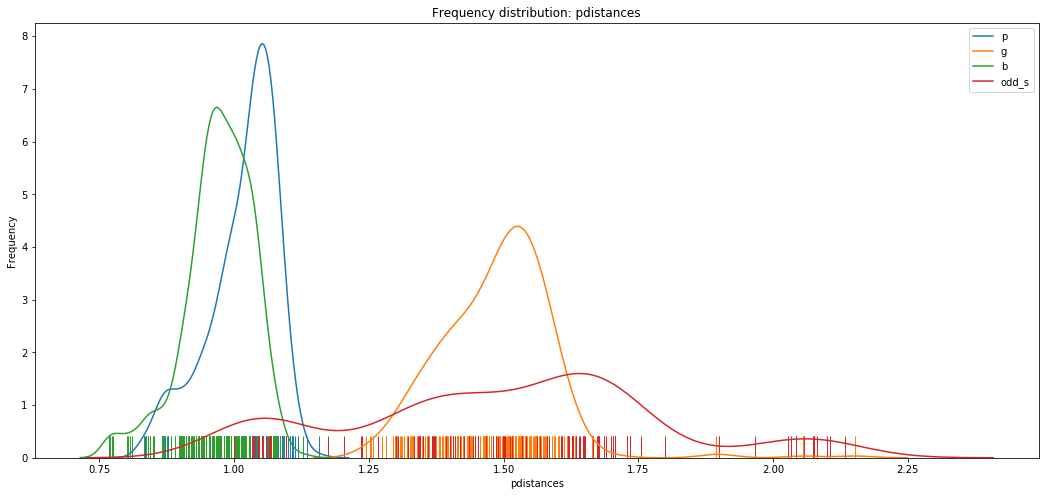

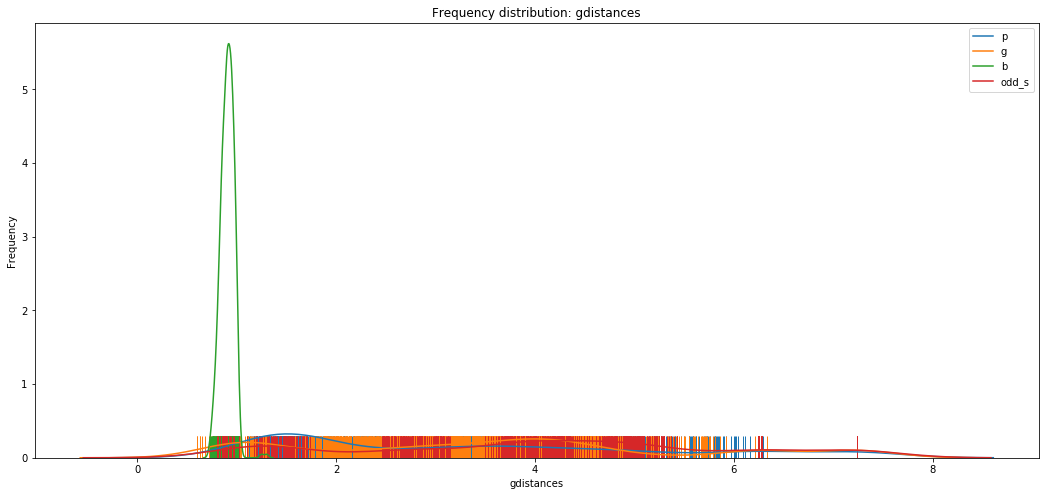

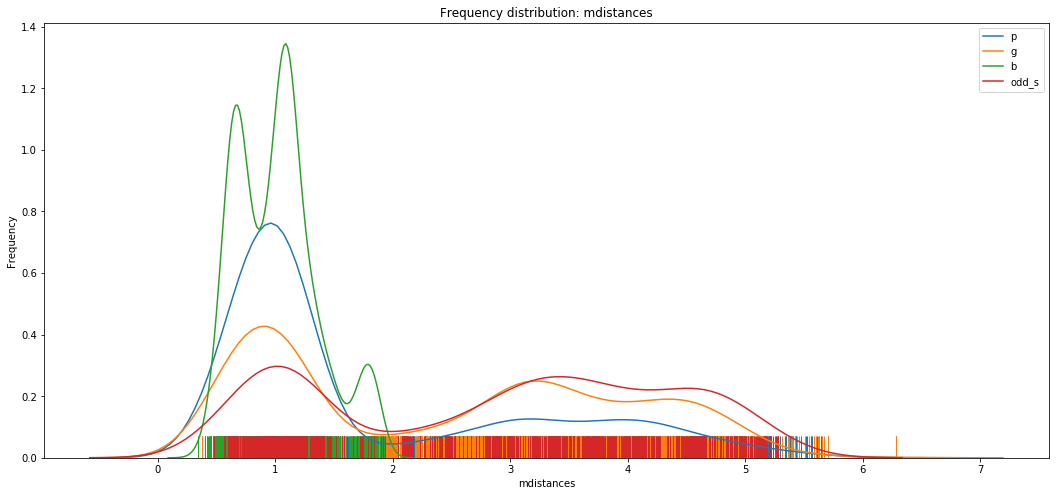

In [12]:

"""Correctly classified"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in passes[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in passes[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
